In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import ortho_group, pearsonr
from scipy.linalg import svdvals, svd
from sklearn.decomposition import PCA

## Singular Value Decomposition
1. Definition: $X = U\Sigma V^T$
    - $\Sigma$: diagonal matrix containing singular values<br>
    - $U, V$: orthogonal matrix<br>
3. SVD always exists for any matrix and is (somewhat) unique
4. Interpretation of SVD
    - SVD of linear transformation: range, null space, rank<br>
    - SVD of data matrix: eigen-decomposition of the covariance matrix<br>
5. Applications <br>
    - Numerically stable matrix inversion / linear regression <br>
    - Dimensionality reduction <br>

Text(0.5, 1.0, '$V^T$')

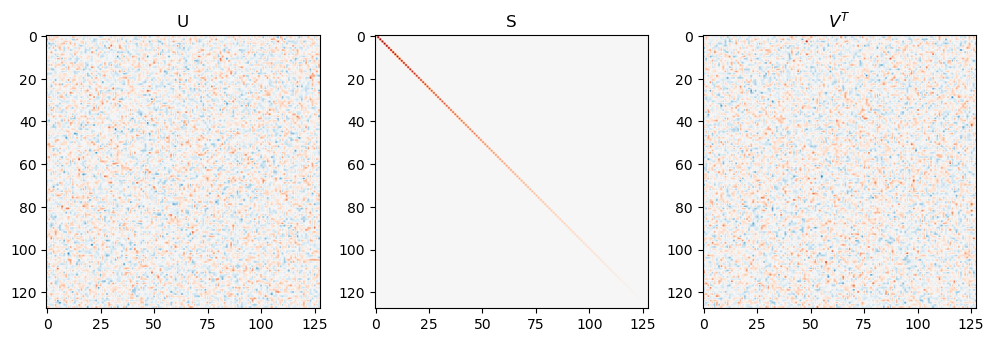

In [2]:
xxx = np.random.randn(128, 128)/np.sqrt(128)

U, S, Vt = svd(xxx)

fig, axes = plt.subplots(1,3, figsize=(12, 6))
axes[0].imshow(U, vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axes[0].set_title('U')
axes[1].imshow(np.diag(S), vmin=-2, vmax=2, cmap='RdBu_r')
axes[1].set_title('S')
axes[2].imshow(Vt, vmin=-0.5, vmax=0.5, cmap='RdBu_r')
axes[2].set_title('$V^T$')

Importantly orthogonal matrices $U$ and $V$ are matrices whose inverse is their transpose $U^TU = UU^T = I$ (same for $V$).

In [3]:
# U, V are orthogonal matrices
print(np.all(np.isclose(np.eye(128), U@U.T)))
print(np.all(np.isclose(np.eye(128), U.T@U)))
print(np.all(np.isclose(np.eye(128), Vt@Vt.T)))
print(np.all(np.isclose(np.eye(128), Vt.T@Vt)))

True
True
True
True


This means that we can interpret any matrix operation as a composition of three operations: roation by $V^T$, streching by $S$, then rotation by $U$.

### Recovery of singular values with synthetic matrices

In [4]:
# constructing random matrices with specific singular value spectrums
S_exp = np.exp(-0.1*np.arange(128))
S_pow3 = 1/np.arange(1,129)**(1.5)
S_pow2 = 1/np.arange(1,129)**(1)
S_pow1 = 1/np.arange(1,129)**(0.5)
S_const = np.ones(128)
S_low_rank = np.concatenate([np.sort(np.random.rand(32))[::-1], 0.0001*np.ones(96)])

S_all = [S_exp, S_pow3, S_pow2, S_pow1, S_const, S_low_rank]

def make_mat_with_sv(sv, m=128, n=256):
    return ortho_group.rvs(m)@np.diag(sv)@ortho_group.rvs(n)[:m]

X_all = [make_mat_with_sv(S) for S in S_all]


Text(0.5, 0, 'Log(# component)')

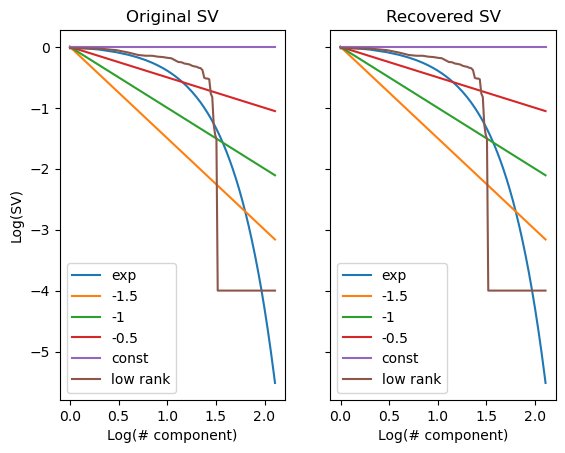

In [5]:
fig, axes = plt.subplots(1,2, sharey=True)

axes[0].plot(np.log10(np.arange(1,129)), np.log10(np.array(S_all).T), label=['exp', '-1.5', '-1', '-0.5', 'const', 'low rank']);
axes[0].set_title('Original SV')
axes[0].legend()

s_recovered_all = [svdvals(X) for X in X_all];

axes[1].plot(np.log10(np.arange(1,129)), np.log10(np.array(s_recovered_all).T), label=['exp', '-1.5', '-1', '-0.5', 'const', 'low rank']);
axes[1].set_title('Recovered SV')
axes[1].legend()

axes[0].set_ylabel('Log(SV)')
axes[0].set_xlabel('Log(# component)')
axes[1].set_xlabel('Log(# component)')

### Interpreting SVD of a linear transformation and using it for pseudoinverse

A $m\times n$ matrix $M$ represent a linear transformation $T: \mathbb{R}^n\to\mathbb{R}^m$ or mappings between vector spaces. Linear transformations have a range (the subspace of $\mathbb{R}^m$ spanned by column space of the corresponding matrix) and a null space (the subspace of $\mathbb{R}^n$ that gets mapped to 0 by $M$). These can be very explicitly represented by SVD.

Text(0.5, 1.0, 'S')

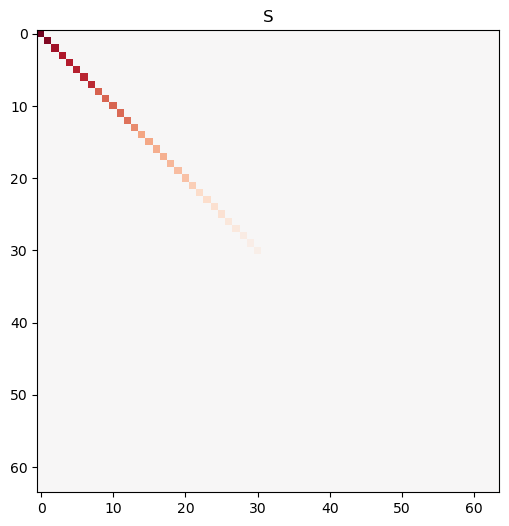

In [6]:
# construct M to have low-rank: 64 non-zero singular values and 64 zero singular values

S_low_rank = np.concatenate([np.sort(np.random.rand(32))[::-1], 0.000*np.ones(32)])
M = make_mat_with_sv(S_low_rank, m=64, n=512).T

U, S, Vt = svd(M, full_matrices=False)


fig, axes = plt.subplots(1,1, figsize=(12, 6))
axes.imshow(np.diag(S), vmin=-1, vmax=1, cmap='RdBu_r')
axes.set_title('S')


Even though the matrix is not full rank, SVD still works perfectly.

In [7]:
print(f"Rank of M is {np.linalg.matrix_rank(M)}") 
print(f"Shape of M is {M.shape}")

Rank of M is 32
Shape of M is (512, 64)


Any column in $V$ that corresponds to a zero singular value is in the *null space* of $M$. Any column in $U$ that corresponds to a non-zero singular value is in the *range* of $M$.<br>
If $M$ is the dataset, then consider a weight vector $w$, and a target that is generated through $y=Mw$.<br>
Let there be another vector $v$ that is in the null space of $M$, then $M(w+v) = Mw+Mv = y+0$. <br>
This means that if $M$ is low rank (aka has colinearity) it is impossible to identify a unique set of ordinary linear regression weights<br>
See example below:

In [8]:
# generate target
w = np.random.randn(64)/np.sqrt(64)
y = M@w+np.random.randn(512)*0.001

# naive implementation of linear regression
w_hat_naive = np.linalg.inv(M.T@M)@M.T@y


Text(0, 0.5, 'Fit parameters')

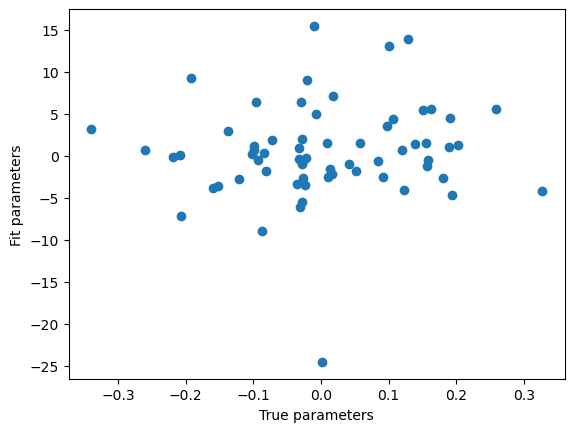

In [9]:
plt.scatter(w, w_hat_naive)
plt.xlabel('True parameters')
plt.ylabel('Fit parameters')

The result is terrible since $M^TM$ is non-invertible. To better understand why this is an issue, see:
$$
M^TM = (USV^T)^TUSV^T = VSU^TUSV^T = VS^2V^T
$$
This means that the square of the singular values are exactly the eigenvalues of the Gram matrix (if the dataset is z-scored, then the Gram matrix is also proportional to the covariance matrix), and the right singular vectors are the eigenvectors of the Gram matrix. <br>
Now consider another matrix of the form $W=VUV^T$, where $U$ is also diagonal. Then $W(M^TM)=VUV^TVS^2V^T=VUS^2V^T$. If $US^2=I$, then $W$ is the inverse of $M^TM$. In an ideal case this is easy to solve, just let $U_{ii}=1/(S_{ii})^2$. However, since some diagonal of S is 0 (due to $M$ being low rank), this leads to division by 0.<br>
Instead, we can try to solve the problem by defining another type of matrix inverse. We know $Mw=USV^Tw=y$, then we can define $\hat{w}=VS^\dagger U^Ty$, where $S^\dagger$ is a diagonal matrix which contains the inverse of $S$'s diagonal elements, except it has 0s where $S$ is zero, avoiding the division by 0 problem (this is the intuition but there are more rigorous derivations for this, see pseudoinverse). 


In [10]:
eps=1e-8 # small value cutoff, any singular value smaller than this will be treated as 0
S_inv = np.where(S>eps, 1/S, 0)
w_hat_svd = (Vt.T@np.diag(S_inv)@U.T)@y

PearsonRResult(statistic=0.7702669533604591, pvalue=9.998714416702584e-14)


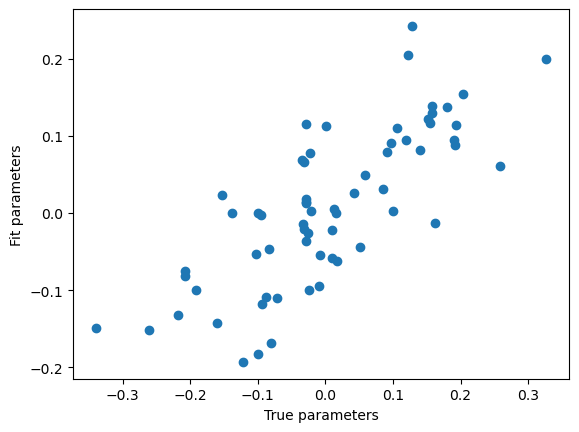

In [11]:
plt.scatter(w, w_hat_svd)
plt.xlabel('True parameters')
plt.ylabel('Fit parameters')
print(pearsonr(w, w_hat_svd))

Not perfect but much better. SVD allows us to isolate the degenerate components of the data matrix, and ignore them in order to avoid numerical instability. This is exactly what numpy uses to solve linear least squares problems.

In [12]:
w_hat_numpy = np.linalg.lstsq(M, y, rcond=None)
print(np.all(np.isclose(w_hat_numpy[0], w_hat_svd)))

True


## Interpreting SVD of a design matrix and using it for dimensionality reduction

Now suppose we want to solve another linear least squares problem. We want a low-rank matrix to approximate the data matrix. Notice that the data matrix has $m\times n$ numbers, but a rank-k approximation ($M_k$) only takes $m\times k+n\times k$ entries, which is much smaller if $k$ is small. Mathematicall, we want
$$
\arg\min_{M_k} ||M-M_k||^2
$$

Again we use the SVD of $M=USV^T$, we can see that $||M||^2 = tr((USV^T)^T(USV^T)) = tr(VS^2V^T) = tr(V^TVS^2) = tr(S^2)$. The norm of a matrix (which equals the total variance of a mean-subtracted dataset) is the sum of its squared singular values. In other words, the total sum of squares of a dataset is equal to the sum of the eigenvalues of its covariance matrix.

/var/folders/vn/04h3k2gd41v70zhrqdwyg9cw0000gp/T/ipykernel_1745/2654516599.py:10: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(eigvals[0][::-1], np.sqrt(eigvals[0][::-1]), label='y=sqrt(x)', color='orange')


Text(0, 0.5, 'Eigenvalues of covariance')

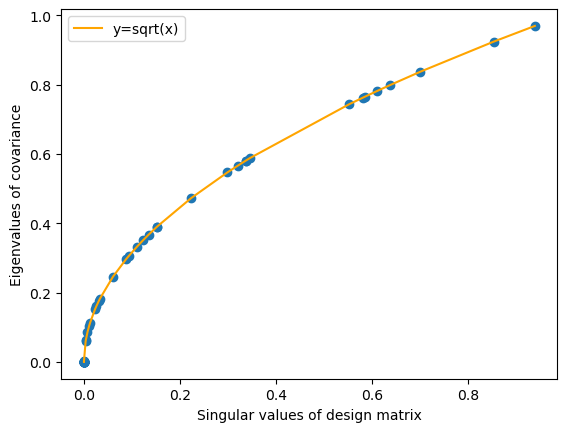

In [13]:
M_jitter = M+np.random.randn(*M.shape)*0.00000 # no jitter, only low rank components

M_centered = (M_jitter-M_jitter.mean(0, keepdims=True)) # center the dataset

eigvals = np.linalg.eigh(M_centered.T@M_centered) # eigenvalues of gran matrix

U_centered, S_centered, Vt_centered = svd(M_centered, full_matrices=False) # singular values of centered design matrix

plt.scatter(eigvals[0][::-1], S_centered)
plt.plot(eigvals[0][::-1], np.sqrt(eigvals[0][::-1]), label='y=sqrt(x)', color='orange')
plt.legend()
plt.xlabel('Singular values of design matrix')
plt.ylabel('Eigenvalues of covariance')

By performing SVD and removing the components with small singular values, we can get a low-rank approximation of the data. <br><br>
For dataset with very bad colinearity (smallest singular value=0), this will lead to no loss of information. <br><br>
By removing each component from the SVD, we remove a part of the dataset whose variance is equal to the square of the singular value. <br><br>
Removing the components of SVD with the smallest singular values is actually the optimal way of achieving low-rank approximation while preserving variance of the original dataset, but the proof is quite involved. Intuitively, if the component you remove is a "mix" of many SVD components, then its variance explaiend will also be a "mix" of the squares of many singular values, which will be larger than the square of the smallest singular value. <br><br>
This is exactly what scikitlearn uses for PCA:

Text(0, 0.5, 'Explained Var. Ratio')

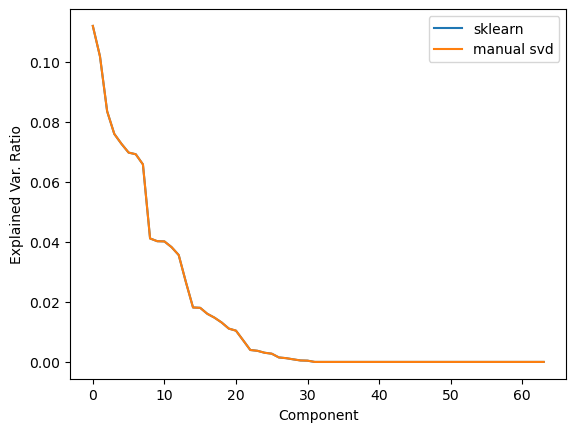

In [15]:
pca = PCA(n_components=64)
pca.fit(M_jitter)
plt.plot(pca.explained_variance_ratio_, label='sklearn')
plt.plot(S_centered[:64]**2/np.sum(S_centered[:64]**2), label='manual svd')
plt.legend()
plt.xlabel('Component')
plt.ylabel('Explained Var. Ratio')

### Other applications

- Partial least squares, canonical correlation, reduced rank regression
- Procrusties alignment / hyperalignment
- ...